<a href="https://colab.research.google.com/github/elizabethyoo/team_9/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis

## autoregression for univariate TS 1-step lookahead forecasting 

## ARIMA for multivariate TS 1-step lookahead forecasting 

In [62]:
# Mount google drive

from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/drive/MyDrive/Group 9 Project Documents/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
root_path

'/content/drive/MyDrive/Group 9 Project Documents/'

In [64]:
import pandas as pd
import glob
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas import read_csv

# Preprocessing 
edit: whoops did not need

In [101]:
hps_state_agg_path = '/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/hps_state_agg.csv'
sbps_agg_month_path = '/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/sbps_agg_month.csv'
unemp_cleaned_path = '/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/unemployment_cleaned.csv'

hps_df = pd.read_csv(hps_state_agg_path)
sbps_df = pd.read_csv(sbps_agg_month_path)
unemp_df = pd.read_csv(unemp_cleaned_path)

FileNotFoundError: ignored

## Extract features of interest


In [102]:
hps_df.info()
hps_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 38 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   EST_ST                                     918 non-null    int64  
 1   YEAR                                       918 non-null    int64  
 2   MONTH                                      918 non-null    int64  
 3   AGE_GRP_18_24                              918 non-null    float64
 4   AGE_GRP_25_39                              918 non-null    float64
 5   AGE_GRP_40_49                              918 non-null    float64
 6   AGE_GRP_50_59                              918 non-null    float64
 7   AGE_GRP_60_69                              918 non-null    float64
 8   AGE_GRP_70_up                              918 non-null    float64
 9   AGE_GRP_less_18                            918 non-null    float64
 10  COVID_VACC_DOSE_not_plan_a

,EST_ST,YEAR,MONTH,AGE_GRP_18_24,AGE_GRP_25_39,AGE_GRP_40_49,AGE_GRP_50_59,AGE_GRP_60_69,AGE_GRP_70_up,AGE_GRP_less_18,COVID_VACC_DOSE_not_plan_all_dose,COVID_VACC_DOSE_plan_to_receive_all_doses,COVID_VACC_DOSE_received_all_doses,EDUCATION_bachelor_or_higher,EDUCATION_high_school_diploma_GED,EDUCATION_less_high school,EDUCATION_some_college_asscte_degree,"INCOME_BEFORE_TAX_$100,000_$149,999","INCOME_BEFORE_TAX_$150,000_$199,999","INCOME_BEFORE_TAX_$200,000_above","INCOME_BEFORE_TAX_$25,000_$34,999","INCOME_BEFORE_TAX_$35,000_$49,999","INCOME_BEFORE_TAX_$50,000_$74,999","INCOME_BEFORE_TAX_$75,000_$99,999","INCOME_BEFORE_TAX_Less_$25,000",RACE_Any_other_race_alone_or_mixed_race,"RACE_Asian,_alone",RACE_Black_alone,RACE_White_alone,FOOD_SCARCITY,HOUSING_INSECURITY,MALE,FEMALE,HISPANIC_ORIGIN,RECVD_COVID_VACC,CHILDCARE_ISSUE
count,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,459.000,306.000
mean,28.961,2020.500,6.500,8.790,27.335,16.541,17.093,17.782,11.497,0.961,0.078,0.562,12.727,30.145,36.532,1.965,31.357,11.699,5.040,5.176,8.402,9.573,13.812,10.347,10.837,6.456,4.348,10.571,78.625,9.639,2.282,48.587,51.413,11.194,60.992,20.399
std,15.685,0.500,2.988,1.953,3.340,1.479,1.644,2.078,1.705,0.605,0.234,1.421,28.611,6.295,5.302,1.104,3.996,2.219,1.666,2.752,2.027,1.941,2.384,1.879,3.207,5.394,5.527,9.862,13.035,2.731,1.017,1.012,1.012,9.446,26.938,6.659
min,1.000,2020.000,1.000,2.995,19.698,10.696,10.152,10.615,5.891,0.000,0.000,0.000,0.000,19.930,14.749,0.000,15.635,6.094,1.608,1.468,3.399,2.707,6.360,5.485,4.227,1.525,0.182,0.223,24.978,2.711,0.307,46.349,48.841,1.690,7.805,8.108
25%,16.000,2020.000,4.000,7.530,25.230,15.569,16.073,16.569,10.452,0.526,0.000,0.000,0.000,26.381,33.455,1.213,28.845,10.145,3.863,3.423,6.968,8.379,12.201,9.102,8.556,3.836,1.794,2.897,70.732,7.607,1.556,47.936,50.666,5.073,39.266,15.710
50%,29.000,2020.500,6.500,8.792,26.920,16.426,17.070,17.831,11.411,0.897,0.000,0.000,0.000,29.297,36.316,1.807,31.322,11.608,4.727,4.390,8.272,9.485,13.663,10.160,10.308,4.940,2.799,7.215,80.647,9.402,2.135,48.498,51.502,8.160,73.897,19.340
75%,42.000,2021.000,9.000,9.917,28.885,17.301,18.160,19.046,12.505,1.281,0.000,0.000,0.000,32.840,39.850,2.433,34.140,13.205,6.051,6.098,9.672,10.800,15.231,11.438,12.522,6.771,4.981,14.641,88.705,11.389,2.834,49.334,52.064,12.073,81.605,24.528
max,56.000,2021.000,12.000,16.970,48.720,26.585,22.867,24.613,16.845,4.499,2.923,8.377,93.339,58.596,51.887,7.863,54.123,19.540,12.411,26.613,15.581,16.073,23.166,17.359,28.377,40.273,41.692,44.598,96.840,22.533,6.498,51.159,53.651,46.734,94.367,38.584


dropping covid vax rate since more than 50% of entries missing 

In [103]:
# Want to subset: YEAR, MONTH, COVID_VACC_DOSE_received_all_doses, HOUSING_INSECURITY, STATE, STATE_ABBR
hps_tmp = hps_df[['YEAR', 'MONTH', 'HOUSING_INSECURITY', 'STATE', 'STATE_ABBR']]

In [104]:
unemp_df.info() 
unemp_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              1040 non-null   object 
 1   date               1040 non-null   object 
 2   unemployment_rate  1038 non-null   float64
dtypes: float64(1), object(2)
memory usage: 24.5+ KB


,unemployment_rate
count,1038.000
mean,6.633
std,3.294
min,1.700
25%,4.325
50%,5.900
75%,7.900
max,29.700


keep unemp_df as is 

In [105]:
sbps_df.info()
sbps_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ST                            884 non-null    object 
 1   DATE_START                    884 non-null    object 
 2   Expected recovery index       884 non-null    float64
 3   Financial stress index        468 non-null    float64
 4   Market challenges index       104 non-null    float64
 5   Market(s) challenges index    52 non-null     float64
 6   Operational challenges index  884 non-null    float64
 7   Overall sentiment index       884 non-null    float64
dtypes: float64(6), object(2)
memory usage: 55.4+ KB


,Expected recovery index,Financial stress index,Market challenges index,Market(s) challenges index,Operational challenges index,Overall sentiment index
count,884.000,468.000,104.000,52.000,884.000,884.000
mean,-0.519,-0.316,0.075,0.078,-0.171,-0.463
std,0.071,0.034,0.026,0.034,0.085,0.098
min,-0.703,-0.500,-0.035,-0.020,-0.670,-0.780
25%,-0.570,-0.330,0.060,0.060,-0.191,-0.515
50%,-0.526,-0.310,0.076,0.080,-0.150,-0.450
75%,-0.467,-0.297,0.092,0.092,-0.115,-0.393
max,-0.305,-0.230,0.125,0.170,-0.007,-0.217


In [106]:
# variables of interst: ST, DATE_START, Expected recovery index, Overall sentiment index
sbps_tmp = sbps_df[['ST', 'DATE_START', 'Expected recovery index', 'Overall sentiment index']]

## TODO (for multivariate prediction!!): Now merge temporary dfs into one df, based on state and date. We need to first parse the dates (monthly granularity), and deal with missing values e.g. missing state names, missing numbers (impute via sample mean?)



# Univariate autogression 


In [109]:
# sbps_tmp
# hps_tmp 
# unemp_df
eri_df = sbps_tmp.drop(['Overall sentiment index'], axis=1)
osi_df = sbps_tmp.drop(['Expected recovery index'], axis=1)

In [112]:
# # eri for california
# eri_df_tmp = eri_df[osi_df['ST'] == 'CA'][['DATE_START', 'Expected recovery index']]
# eri_df_tmp.to_csv('/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/eri_univariate.csv', index=False)


In [113]:
# # osi for california
# osi_df_tmp = osi_df[osi_df['ST'] == 'CA'][['DATE_START', 'Overall sentiment index']]
# osi_df_tmp.to_csv('/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/osi_univariate.csv', index=False)


Check for optimal lag value, autocorrelation

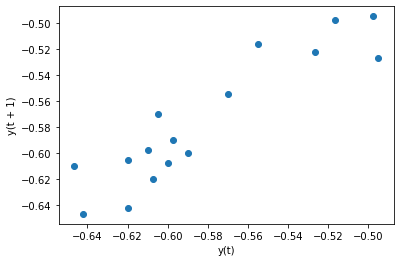

In [114]:
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
series = read_csv('/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/eri_univariate.csv', header=0, index_col=0)
lag_plot(series)
pyplot.show()

In [115]:
series

,Expected recovery index
DATE_START,
2020-04-30,-0.620
2020-05-31,-0.642
2020-06-30,-0.647
2020-08-31,-0.610
2020-09-30,-0.597
2020-10-31,-0.590
2020-11-30,-0.600
2020-12-31,-0.607
2021-01-31,-0.620


 some positive correlation, now let us numerically verify

In [116]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
series = read_csv('/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/eri_univariate.csv', header=0, index_col=0)
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

      t-1   t+1
t-1 1.000 0.914
t+1 0.914 1.000


### Autoregressive model for out-of-sample predictions 
N-step lookahead for a fixed state (CA)



In [18]:
# static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset
series = read_csv('/content/drive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/eri_univariate.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.reset_index(drop=True, inplace=True)

# fit model
NUM_STEPS = 3
X = series.values
train = X
model = AutoReg(train, lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions 
predictions = model_fit.predict(len(train), end= len(train) + NUM_STEPS - 1)
for i in range(len(predictions)):
	print('predicted=%f' % predictions[i])

OSError: ignored

Generalize to all 51 states


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import glob
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
file_path = '/content/drive/MyDrive/Group 9 Project Documents/Datasets/hps_sbps_unemp_merged.csv'
cols = list(pd.read_csv(file_path, nrows =1))
df = pd.read_csv(file_path,  usecols =[i for i in cols if i != 'Unnamed: 0'])

In [4]:
df.MONTH = df.MONTH.astype(str)
df.YEAR = df.YEAR.astype(str)
if len(df.MONTH) ==1:
  df.MONTH = "0"+df.MONTH

df['date'] = pd.to_datetime(df['YEAR']+df['MONTH'], format='%Y%m')
df.set_index(df['date'], inplace =True)

In [5]:
df.columns # 'Expected recovery index', 'date', 'Overall sentiment index'

Index(['STATE_ABBR', 'YEAR', 'MONTH', 'AGE_GRP_18_24', 'AGE_GRP_25_39',
       'AGE_GRP_40_49', 'AGE_GRP_50_59', 'AGE_GRP_60_69', 'AGE_GRP_70_up',
       'AGE_GRP_less_18', 'COVID_VACC_DOSE_not_plan_all_dose',
       'COVID_VACC_DOSE_plan_to_receive_all_doses',
       'COVID_VACC_DOSE_received_all_doses', 'EDUCATION_bachelor_or_higher',
       'EDUCATION_high_school_diploma_GED', 'EDUCATION_less_high school',
       'EDUCATION_some_college_asscte_degree',
       'INCOME_BEFORE_TAX_$100,000_$149,999',
       'INCOME_BEFORE_TAX_$150,000_$199,999',
       'INCOME_BEFORE_TAX_$200,000_above', 'INCOME_BEFORE_TAX_$25,000_$34,999',
       'INCOME_BEFORE_TAX_$35,000_$49,999',
       'INCOME_BEFORE_TAX_$50,000_$74,999',
       'INCOME_BEFORE_TAX_$75,000_$99,999', 'INCOME_BEFORE_TAX_Less_$25,000',
       'RACE_Any_other_race_alone_or_mixed_race', 'RACE_Asian,_alone',
       'RACE_Black_alone', 'RACE_White_alone', 'FOOD_SCARCITY',
       'HOUSING_INSECURITY', 'MALE', 'FEMALE', 'HISPANIC_ORIGIN',
 

In [6]:
!pip install ipdb
import ipdb

In [1]:
# static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime as dt
# load dataset
series = read_csv('/content/drive/MyDrive/Group 9 Project Documents/Datasets/hps_sbps_unemp_merged.csv') #header=0, index_col=0, parse_dates=True, squeeze=True
#series.reset_index(drop=True, inplace=True)

for state in df.STATE_ABBR.unique():
  #df_tmp = np.array(df[df['STATE_ABBR'] == state][['Expected recovery index', 'date']].values)
  df_tmp = df[df['STATE_ABBR'] == state][['Expected recovery index', 'date']].reset_index(drop=True)
  df_tmp['index'] = df_tmp.index
  df_tmp.set_index('date', inplace=True)
  df_tmp = df_tmp[['index', 'Expected recovery index']]
  
  series = df_tmp.values

  # fit model
  NUM_STEPS = 3
  X = np.transpose(series)
  train = X
  #ipdb.set_trace()
  model = AutoReg(train, lags=1)
  model_fit = model.fit()
  print('Coefficients: %s' % model_fit.params, state)
    # # make predictions 
    # predictions = model_fit.predict(len(train), end= len(train) + NUM_STEPS - 1)
    # for i in range(len(predictions)):
    #   print('predicted=%f' % predictions[i])
  #  feature_1 ='Expected recovery index'
  #  feature_2 = 'Overall sentiment index'
  #  title = 'Expected recovery index & Overall sentiment index: '
  #  df_state = df.loc[df['STATE_ABBR']==state,:]
  #  fig,ax = plt.subplots(figsize =(10,4))
  #  ax.plot(df_state.index, df_state[feature_1], color="red", marker="o")
  #  ax.set_xlabel("Date",fontsize=14)
  #  ax.set_ylim([-1,0])
  #  ax.set_ylabel(feature_1,color="red",fontsize=14)

  #  ax2=ax.twinx()
  #  ax2.plot(df_state.index, df_state[feature_2],color="blue",marker="o")
  #  ax2.set_ylabel(feature_2,color="blue",fontsize=14)
  #  ax2.set_ylim([-1,1])
  #  plt.title(title +state)
  #  plt.show()


NameError: ignored

In [ ]:
# static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg


# load dataset
series = read_csv('/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/eri_univariate.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


series.reset_index(drop=True, inplace=True)

# fit model
NUM_STEPS = 3
X = series.values
train = X
model = AutoReg(train, lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions 
predictions = model_fit.predict(len(train), end= len(train) + NUM_STEPS - 1)
for i in range(len(predictions)):
	#print state name 
  print('predicted=%f' % predictions[i])
 

In [ ]:
# static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import ipdb 

# load dataset
df = read_csv('/content/drive/MyDrive/Group 9 Project Documents/Datasets/hps_sbps_unemp_merged.csv')

ipdb.set_trace()
ny_df = df[df['STATE_ABBR'] == 'NY'][['Expected recovery index', 'date']]
ms_df = df[df['STATE_ABBR'] == 'MS'][['Expected recovery index', 'date']]
# series.reset_index(drop=True, inplace=True)
ipdb.set_trace()
# # fit model
# NUM_STEPS = 3
# X = series.values
# train = X
# model = AutoReg(train, lags=1)
# model_fit = model.fit()
# print('Coefficients: %s' % model_fit.params)
ipdb.set_trace()
# # make predictions 
# predictions = model_fit.predict(len(train), end= len(train) + NUM_STEPS - 1)
# for i in range(len(predictions)):
# 	print('predicted=%f' % predictions[i])


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 332, in set_trace
    sys.settrace(self.trace_dispatch)



--Return--
None
> <ipython-input-2-765e21137b8f>(12)<module>()
     11 
---> 12 ipdb.set_trace()
     13 ny_df = df[df['STATE_ABBR'] == 'NY'][['Expected recovery index', 'date']]

Index(['Unnamed: 0', 'STATE_ABBR', 'YEAR', 'MONTH', 'AGE_GRP_18_24',
       'AGE_GRP_25_39', 'AGE_GRP_40_49', 'AGE_GRP_50_59', 'AGE_GRP_60_69',
       'AGE_GRP_70_up', 'AGE_GRP_less_18', 'COVID_VACC_DOSE_not_plan_all_dose',
       'COVID_VACC_DOSE_plan_to_receive_all_doses',
       'COVID_VACC_DOSE_received_all_doses', 'EDUCATION_bachelor_or_higher',
       'EDUCATION_high_school_diploma_GED', 'EDUCATION_less_high school',
       'EDUCATION_some_college_asscte_degree',
       'INCOME_BEFORE_TAX_$100,000_$149,999',
       'INCOME_BEFORE_TAX_$150,000_$199,999',
       'INCOME_BEFORE_TAX_$200,000_above', 'INCOME_BEFORE_TAX_$25,000_$34,999',
       'INCOME_BEFORE_TAX_$35,000_$49,999',
       'INCOME_BEFORE_TAX_$50,000_$74,999',
       'INCOME_BEFORE_TAX_$75,000_$99,999', 'INCOME_BEFORE_TAX_Less_$25,000',
       '